In [1]:
import sys
sys.path.append('./util')
import json
import numpy as np
import pandas as pd
import whdr_py3 as whdr
import input_queues as iq
import scipy as sp
import tensorflow as tf
import cnn_helpers as chlp

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# overall final results:

In [2]:
is_sample = True
data_dir = 'data/'
batch_size = 8
num_epochs = 2
image_shape = [340, 340, 3]
norm = True

In [3]:
if is_sample:
    sample = 'sample_'
else:
    sample = ''

In [4]:
# import training data:
file = sample + 'data_iiw_train.csv'
df_train = pd.read_csv(filepath_or_buffer=data_dir + file, sep=',', header=None,
                       names=['img', 'json_label'])
# complete image paths:
df_train = data_dir + df_train

# instantiate a data queue for feeding data in (mini) batches to cnn:
data_train = iq.DataQueue(df=df_train, batch_size=batch_size,
                          num_epochs=num_epochs)

In [5]:
deq_train = data_train.dequeue()
df_whdr, imgs, imgs_original, labels, labels_original = iq.next_batch_iiw(deq=deq_train, output_shape=image_shape, norm=True)

/Users/udodehm/workspace/image_decomposition/input_queues.py:794: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['x'] = (df_point_crop['x'] * img.shape[1] - x_start) / output_shape[1]
/Users/udodehm/workspace/image_decomposition/input_queues.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_point_crop['y'] = (df_point_crop['y'] * img.shape[0] - y_start) / output_shape[0]
/Users/udodehm/workspace/image_decomposition/input_queues.py:842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

2.7182818284590451

In [21]:
np.exp(1)**(-1)

0.36787944117144233

In [23]:
np.log(0.36787944)

-1.0000000031843104

In [7]:
sigmoid_gain = 1
pp1=.2
pp2=0.21
delta = 0.1
# original definition:
darker1 = pp2 / pp1 - (1 + delta)
darker2 = pp1 / pp2 - (1 + delta)
print(f'p1 darker original: {darker1 > 0}')
print(f'{1 / (1 + np.exp(- darker1))}')
print(f'p2 darker original: {darker2 > 0}')

print(f'{1 / (1 + np.exp(- darker2))}')

# new definition:
darker1new = pp2 - pp1 - (delta * (pp1 + pp2) / 2)
darker2new = pp1 - pp2 - (delta * (pp1 + pp2) / 2)
same12 = - np.abs(pp1 - pp2) + (delta * (pp1 + pp2) / 2)
print(f'p1 darker new     : {darker1new}')
print(f'p2 darker new     : {darker2new}')
print(f'p1 and p2 same    : {same12}')
print(f'p1 darker new     : {darker1new > 0}')
print(f'p2 darker new     : {darker2new > 0}')
print(f'p1 and p2 same    : {same12>0}')
proba_total = np.exp(sigmoid_gain * darker1new) + np.exp(sigmoid_gain * darker2new) + np.exp(sigmoid_gain * same12)
probap1 = np.exp(sigmoid_gain * darker1new) / proba_total
probap2 = np.exp(sigmoid_gain * darker2new) / proba_total
proba_same = np.exp(sigmoid_gain * same12) / proba_total
print(f'propa p1 darker : {probap1}')
print(f'propa p2 darker : {probap2}')
print(f'propa p1/p2 same: {proba_same}')
print(proba_total)

p1 darker original: False
0.4875026035157896
p2 darker original: False
0.4631621095276921
p1 darker new     : -0.010500000000000023
p2 darker new     : -0.030499999999999985
p1 and p2 same    : 0.010500000000000023
p1 darker new     : False
p2 darker new     : False
p1 and p2 same    : True
propa p1 darker : 0.33317554972855834
propa p2 darker : 0.32657823182218176
propa p1/p2 same: 0.34024621844925984
2.97007068308


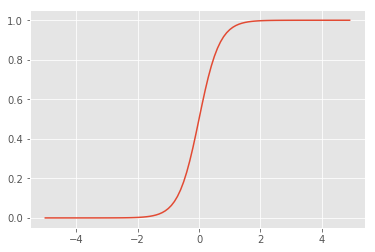

In [149]:
sigmoid_gain = 3
x = np.arange(-5, 5, 0.1)
y = 1 / (1 + np.exp(-sigmoid_gain * x))
plt.plot(x,y)

In [ ]:
# convert images in batch to greyscale (1 cheannel -> mean):
imgs_grey_tf = tf.reduce_mean(reflectance, axis=3)
# select pixels which are compared with each other (comp_p1_batch contains
# all pixels that represent point1 and comp_p2_batch contains all pixels
# that represent point2 over all samples in the batch. Points in
# comp_p1_batch and comp_p2_batch are in the same order (important for
# comparison)):
comp_p1_batch = tf.gather_nd(imgs_grey_tf, point1)
comp_p2_batch = tf.gather_nd(imgs_grey_tf, point2)

# define/convert to pixel threshold:
comp_p1_batch = tf.maximum(comp_p1_batch, 1e-10)
comp_p2_batch = tf.maximum(comp_p2_batch, 1e-10)

assert comp_p1_batch.shape==comp_p2_batch.shape, 'Missmatch in point ' + \
       'comparison length: ' + \
       'comp_p1_batch.shape={}, '.format(comp_p1_batch.shape) + \
       'comp_p2_batch.shape={}.'.format(comp_p2_batch.shape)
# init tensors for human comparison score:
# pixel compare to approx. same darkness:
comparisons_eq = tf.zeros_like(comp_p1_batch, dtype=tf.int32)
# pixel 1 is darker than px 2:
comparisons_p1_darker = tf.ones_like(comp_p1_batch, dtype=tf.int32)
# pixel 2 is darker than px 1:
comparisons_p2_darker = tf.ones_like(comp_p1_batch, dtype=tf.int32) * 2
# select 1 if px 1 is darker than px 2:
px1_darker = tf.where(condition=comp_p2_batch / comp_p1_batch > 1.0 + delta,
                      x=comparisons_p1_darker, y=comparisons_eq)
# select 2 if px 2 is darker than px 1:
px2_darker = tf.where(condition=comp_p1_batch / comp_p2_batch > 1.0 + delta,
                      x=comparisons_p2_darker, y=comparisons_eq)
# combine above by summing (-> 0 belongs to approx the same darkness):
darker = px1_darker + px2_darker

# compare human labels to algorithm darker predictions:
hum_alg_comp = tf.not_equal(darker, human_labels)
# summed weights:
weight_sum = tf.reduce_sum(weights)
# only select such weights that belong to prediction - human label mismatch:
error_weights = tf.where(condition=hum_alg_comp,
                         x=weights,
                         y=tf.zeros_like(hum_alg_comp, dtype=tf.float32))
# sum all error_weights
error_sum = tf.reduce_sum(error_weights)
# get whdr over batch:
result error_sum / weight_sum

In [6]:
p1 = tf.placeholder(dtype=tf.int32)
p2 = tf.placeholder(dtype=tf.int32)
# get the human darker labels:
human_labels = tf.placeholder(dtype=tf.int32)
# list of weights/darker scores:
darker_weights = tf.placeholder(dtype=tf.float32)

imgs_tf = tf.placeholder(dtype=tf.float32)
whdr_batch = chlp.compute_whdr_tf(reflectance=imgs_tf, point1=p1, point2=p2,
                                  human_labels=human_labels,
                                  weights=darker_weights, delta=0.1)

In [7]:
with tf.Session() as sess:
    fd = {imgs_tf: imgs,
          p1: df_whdr[['batch_nr', 'y1', 'x1']].values,
          p2: df_whdr[['batch_nr', 'y2', 'x2']].values,
          human_labels: df_whdr['darker'].values,
          darker_weights: df_whdr['darker_score'].values}
    whdr_b = sess.run(whdr_batch, feed_dict=fd)
whdr_b

0.5593006

(340, 340, 3)

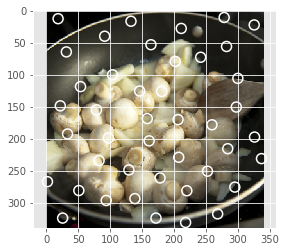

In [8]:
i = 2
plt.imshow(imgs[i])
plt.scatter(x=pd.DataFrame(labels[i]['intrinsic_points'])['x']*imgs[i].shape[1], 
            y=pd.DataFrame(labels[i]['intrinsic_points'])['y']*imgs[i].shape[0], edgecolors='w',
            s=100,
            marker='o', 
            facecolors='None',
            linewidth=1.5)
# for i, txt in enumerate(df_point[['id', 'x', 'y']].values):
#     plt.annotate(txt[0], (txt[1]*img.shape[1],txt[2]*img.shape[0]))
imgs[i].shape

(356, 512, 3)

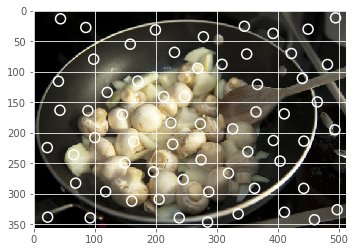

In [9]:
plt.imshow(imgs_original[i])
plt.scatter(x=pd.DataFrame(labels_original[i]['intrinsic_points'])['x']*imgs_original[i].shape[1], 
            y=pd.DataFrame(labels_original[i]['intrinsic_points'])['y']*imgs_original[i].shape[0], edgecolors='w',
            s=100,
            marker='o', 
            facecolors='None',
            linewidth=1.5)
# for i, txt in enumerate(df_point[['id', 'x', 'y']].values):
#     plt.annotate(txt[0], (txt[1]*img.shape[1],txt[2]*img.shape[0]))
imgs_original[i].shape

In [12]:
whdr_metric = whdr.compute_whdr(reflectance=imgs[i], judgements=labels[i], delta=0.10)
whdr_metric

0.5164998283322323

In [13]:
whdr_metric = whdr.compute_whdr(reflectance=imgs_original[i], judgements=labels_original[i], delta=0.10)
whdr_metric

0.44671778611333834

# development process:

# Import data:

In [11]:
# import iiw dataset:
df_iiw = pd.read_csv(filepath_or_buffer=data_dir + 'data_iiw_complete.csv', sep=',',
                     names=['image_path', 'label_path'])
df_iiw = data_dir + df_iiw
df_iiw.head(n=2)

,image_path,label_path
0,data/iiw-dataset/data/54.png,data/iiw-dataset/data/54.json
1,data/iiw-dataset/data/63.png,data/iiw-dataset/data/63.json


In [12]:
# import an image and json label:
img = sp.misc.imread(name=df_iiw.loc[10, 'image_path'], flatten=False, mode='RGB')
with open(df_iiw.loc[10, 'label_path'], 'r', encoding='utf-8') as infile:
    jfile = json.load(infile)

# define a (copied) json label file where the crucial features 
# 'intrinsic_points' and 'intrinsic_comparisons' are overwritten 
# by the cropped data points:
jfile_crop = jfile.copy()

In [13]:
# convert these dictionaries to pd.DataFrames:
df_point = pd.DataFrame(jfile['intrinsic_points'])
df_comparisons = pd.DataFrame(jfile['intrinsic_comparisons'])

In [14]:
df_point

,id,min_separation,opaque,opaque_method,opaque_responses,opaque_score,sRGB,x,y
0,2159835,0.03,False,C,"[{'id': 1597178, 'mturk_worker_id': 'A3163PFOU...",-0.211024,e3cbc7,0.606609,0.423668
1,2159834,0.03,True,C,"[{'id': 1597179, 'mturk_worker_id': 'A3163PFOU...",0.911177,beb0a3,0.510209,0.315666
2,2159833,0.03,True,C,"[{'id': 1597072, 'mturk_worker_id': 'A3163PFOU...",0.911177,65331a,0.240950,0.340200
3,2159832,0.03,True,C,"[{'id': 1597180, 'mturk_worker_id': 'A3163PFOU...",0.911177,562610,0.076264,0.037651
4,2159831,0.03,True,C,"[{'id': 1597181, 'mturk_worker_id': 'A3163PFOU...",0.911177,a97e5e,0.430010,0.816535
5,2159830,0.03,False,C,"[{'id': 1597208, 'mturk_worker_id': 'A3163PFOU...",-0.058945,532f23,0.626682,0.332323
6,2159829,0.03,True,C,"[{'id': 1597073, 'mturk_worker_id': 'A3163PFOU...",0.911177,64361e,0.828539,0.524214
7,2159828,0.03,False,C,"[{'id': 1597182, 'mturk_worker_id': 'A3163PFOU...",-0.058945,392a13,0.664718,0.252025
8,2159827,0.03,True,C,"[{'id': 1597183, 'mturk_worker_id': 'A3163PFOU...",0.911177,946645,0.754718,0.970518
9,2159826,0.03,True,C,"[{'id': 1597074, 'mturk_worker_id': 'A3163PFOU...",0.911177,c5a191,0.460192,0.970061


# Crop image (see also input_queues.py next_batch() function):

In [15]:
img.shape

(341, 512, 3)

In [16]:
output_shape = (340, 340, 3)

In [17]:
y_start = np.random.randint(img.shape[0] - output_shape[0])
x_start = np.random.randint(img.shape[1] - output_shape[1])
img_crop = img[y_start:y_start + output_shape[0], x_start:x_start + output_shape[1], :]

In [18]:
y_start / img.shape[0]

0.0

In [19]:
x_start / img.shape[1]

0.2890625

# Filter for the corresponding points in 'intrinsic_points' that are in cropped image field:

In [20]:
df_point_crop = df_point[(df_point['x'] > (x_start / img.shape[1])) &
                         (df_point['x'] < (x_start + output_shape[1]) / img.shape[1]) &
                         (df_point['y'] > y_start / img.shape[0]) &
                         (df_point['y'] < (y_start + output_shape[0]) / img.shape[0])]
df_point_crop

,id,min_separation,opaque,opaque_method,opaque_responses,opaque_score,sRGB,x,y
0,2159835,0.03,False,C,"[{'id': 1597178, 'mturk_worker_id': 'A3163PFOU...",-0.211024,e3cbc7,0.606609,0.423668
1,2159834,0.03,True,C,"[{'id': 1597179, 'mturk_worker_id': 'A3163PFOU...",0.911177,beb0a3,0.510209,0.315666
4,2159831,0.03,True,C,"[{'id': 1597181, 'mturk_worker_id': 'A3163PFOU...",0.911177,a97e5e,0.430010,0.816535
5,2159830,0.03,False,C,"[{'id': 1597208, 'mturk_worker_id': 'A3163PFOU...",-0.058945,532f23,0.626682,0.332323
6,2159829,0.03,True,C,"[{'id': 1597073, 'mturk_worker_id': 'A3163PFOU...",0.911177,64361e,0.828539,0.524214
7,2159828,0.03,False,C,"[{'id': 1597182, 'mturk_worker_id': 'A3163PFOU...",-0.058945,392a13,0.664718,0.252025
8,2159827,0.03,True,C,"[{'id': 1597183, 'mturk_worker_id': 'A3163PFOU...",0.911177,946645,0.754718,0.970518
9,2159826,0.03,True,C,"[{'id': 1597074, 'mturk_worker_id': 'A3163PFOU...",0.911177,c5a191,0.460192,0.970061
10,2159825,0.03,True,C,"[{'id': 1597184, 'mturk_worker_id': 'A3163PFOU...",0.911177,612e19,0.647544,0.029369
12,2159823,0.03,False,C,"[{'id': 1597254, 'mturk_worker_id': 'A3163PFOU...",-0.211024,71635a,0.557903,0.443365


In [21]:
# calculate new updated/croped relative coordinates:
df_point_crop['x'] = (df_point_crop['x'] * img.shape[1] - x_start) / output_shape[1]
df_point_crop['y'] = (df_point_crop['y'] * img.shape[0] - y_start) / output_shape[0]

/Users/udodehm/.venvs/venv_tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/udodehm/.venvs/venv_tf/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# save 'intrinsic_points' to new json file:
jfile_crop['intrinsic_points'] = df_point_crop.to_dict(orient='records')

# Filter for the corresponding points in 'intrinsic_comparisons' that are in cropped image field:

In [23]:
df_comparisons_crop = df_comparisons[df_comparisons['point1'].isin(df_point_crop['id']) & 
                                     df_comparisons['point2'].isin(df_point_crop['id'])]

In [24]:
# for calculating the metric later it is important to do some preprocessing steps:
# first get only those entries that have ('1', '2', 'E') as feature 'darker':
df_comparisons_crop = df_comparisons_crop[df_comparisons_crop['darker'].isin(('1', '2', 'E'))]

# ensure that 'darker_score' is not None:
df_comparisons_crop = df_comparisons_crop[df_comparisons_crop['darker_score'].notnull()]

# ensure that 'darker_score' is > 0:
df_comparisons_crop = df_comparisons_crop[df_comparisons_crop['darker_score']>0]

# delete comparisons that contain opaque points ('opaque'==False):
df_comparisons_crop = df_comparisons_crop.merge(right=df_point[['id', 'opaque', 'x', 'y']], 
                                                left_on='point1', right_on='id', 
                                                how='left', suffixes=('', '_1'))
df_comparisons_crop = df_comparisons_crop.merge(right=df_point[['id', 'opaque', 'x', 'y']], 
                                                left_on='point2', right_on='id', 
                                                how='left', suffixes=('', '2'))
df_comparisons_crop = df_comparisons_crop[(df_comparisons_crop['opaque']==True) & 
                                          (df_comparisons_crop['opaque2']==True)]
df_comparisons_crop.drop(['id_1', 'opaque', 'id2', 'opaque2'], axis=1, inplace=True)
df_comparisons_crop.rename(columns={'x':'x1', 'y':'y1'}, inplace=True)

In [25]:
df_comparisons_crop_whdr = df_comparisons_crop[['darker', 'x1', 'y1', 'x2', 'y2']]

In [42]:
# introduce new numerical darker column:
df_comparisons_crop_whdr['darker_num'] = df_comparisons_crop_whdr.loc[:,'darker']
# replace 'E' (equal) with 3, transform '1' and '2' to 1 and 2:
df_comparisons_crop_whdr['darker_num'] = df_comparisons_crop_whdr['darker_num'].apply(lambda x: 3 if x=='E' else int(x))

/Users/udodehm/.venvs/venv_tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [32]:
df_comparisons_crop_whdr[['x1', 'y1', 'x2', 'y2']].values

(570, 4)

In [43]:
jfile_crop['intrinsic_comparisons'] =df_comparisons_crop.drop(['x1', 'y1', 'x2', 'y2'], axis=1).to_dict(orient='records')

# Calculate whdr metric:

In [21]:
whdr.compute_whdr(reflectance=img, judgements=jfile, delta=0.10)

0.2539263836140903

In [22]:
whdr.compute_whdr(reflectance=img_crop, judgements=jfile_crop, delta=0.10)

0.26774754294963987

# Plots

(341, 512, 3)

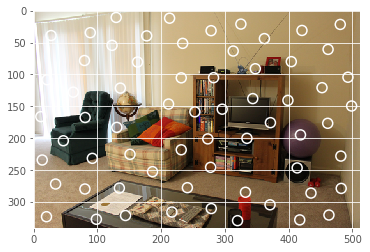

In [23]:
plt.imshow(img)
plt.scatter(x=df_point['x']*img.shape[1], y=df_point['y']*img.shape[0], edgecolors='w',
            s=100, marker='o', facecolors='None',
            linewidth=1.5)
# for i, txt in enumerate(df_point[['id', 'x', 'y']].values):
#     plt.annotate(txt[0], (txt[1]*img.shape[1],txt[2]*img.shape[0]))
img.shape

(340, 340, 3)

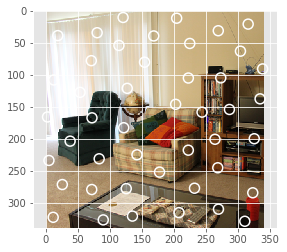

In [24]:
plt.imshow(img_crop)
plt.scatter(x=df_point_crop['x']*img_crop.shape[1], y=df_point_crop['y']*img_crop.shape[0], edgecolors='w',
            s=100, marker='o', facecolors='None',
            linewidth=1.5)
# for i, txt in enumerate(df_point[['id', 'x', 'y']].values):
#     plt.annotate(txt[0], (txt[1]*img.shape[1],txt[2]*img.shape[0]))
img_crop.shape

In [42]:
# position: relative_position*old_image_px_size-
df_point_crop['x']*img.shape[1]-x_start

22    61.778057
38    60.693237
50    24.289988
Name: x, dtype: float64

In [46]:
df_point_crop['x']*img.shape[1]-x_start

22    61.778057
38    60.693237
50    24.289988
Name: x, dtype: float64

In [50]:
(df_point_crop['x']-x_start/img.shape[1])*img_crop.shape[1]

22   -111103.455512
38   -111103.457630
50   -111103.528730
Name: x, dtype: float64

In [21]:
img_crop.shape[1]

100

In [19]:
(df_point_crop['x']*img.shape[1]-x_start)/img_crop.shape[1]

41    0.232283
49    0.823256
55    0.119555
56    0.616079
Name: x, dtype: float64

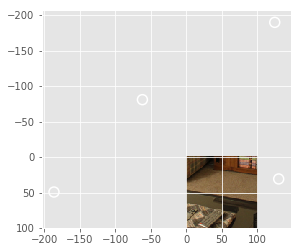

In [26]:
plt.imshow(img_crop)
plt.scatter(x=df_point_crop['x']*img.shape[1]-x_start, y=df_point_crop['y']*img.shape[0]-y_start, edgecolors='w',
            s=100, marker='o', facecolors='None',
            linewidth=1.5)

In [44]:
x_start

217

In [45]:
y_start

229

# Test: start for plotting comparison connections between points:

In [25]:
df_comparisons2 = df_comparisons.merge(right=df_point[['id', 'x', 'y']], 
                                       left_on='point1', right_on='id', 
                                       how='left')
df_comparisons2.rename(columns={'x':'point1_x', 
                                'y': 'point1_y',
                                'id_x': 'id'}, 
                       inplace=True)
df_comparisons2.drop('id_y', axis=1, inplace=True)
df_comparisons3 = df_comparisons2.merge(right=df_point[['id', 'x', 'y']], 
                                        left_on='point2', right_on='id', 
                                        how='left')
df_comparisons3.rename(columns={'x':'point2_x', 
                                'y': 'point2_y',
                                'id_x': 'id'}, 
                       inplace=True)
df_comparisons3.drop('id_y', axis=1, inplace=True)